# PMFs of Basic Amino Acids
In this notebook, we plot PMFs of membrane translocation for neutral, charged, and titratable peptides from all-atom and CG simulations.

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np, pandas as pd
import os, sys, json, shutil
from math import asinh, sqrt, pi
import pandas as pd
import glob
import mdtraj as md
from scipy.optimize import curve_fit
from scipy.optimize import least_squares
from scipy.linalg import svd
from scipy.interpolate import Akima1DInterpolator
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
import warnings
warnings.filterwarnings('ignore')
try:
    workdir
except NameError:
    workdir=%pwd
else:
    %cd $workdir

/Users/giulio/Repos/SI-peptidebilayer


In [20]:
plt.rcParams.update({'font.size': 12,'xtick.major.pad':3,'ytick.major.pad':3,'figure.dpi':80,
                     'xtick.major.size':6,'ytick.major.size':6,'legend.fontsize':12,
                     'xtick.direction':'out','ytick.direction':'out','axes.labelsize':12,
                     'axes.linewidth':1.2,'xtick.labelsize':12,'ytick.labelsize':12,
                     'xtick.major.width':1.2, 'ytick.major.width':1.2})

In [21]:
if os.path.isfile('allatom.p'):
    allatom = pd.read_pickle('allatom.p')
allatom[['min0','max0','min1','max1']]

,min0,max0,min1,max1
AminoAcid,,,,
H,-4.743200,7.607264,-5.029907,29.600420
K,-2.231119,8.269130,-3.675741,31.873755
R,-1.422247,19.601958,-11.292982,30.526298


In [22]:
if os.path.isfile('allatom.p'):
    allatom = pd.read_pickle('allatom.p')
allatom[['xmin0','xmin1']]

,xmin0,xmin1
AminoAcid,,
H,[1.334198],[1.562473]
K,[1.168875],[1.450835]
R,[1.248829],[1.238702]


In [23]:
if os.path.isfile('titr.p'):
    titr = pd.read_pickle('titr.p')
titr[['min0','max0','min1','max1','min0/1','max0/1']]

min0      max0      min1       max1    min0/1  \
ah at  aa R   pKa                                                        
25 -35 2  2.0 6.04  -0.427600  10.63620 -3.884218  28.182034 -1.750360   
              10.67 -0.427600  10.63620 -3.884218  28.182034 -3.829730   
35 -35 3  2.5 12.10 -4.632900  17.54420 -5.700900  28.497400 -5.800047   
44 -44 2  2.5 12.10 -3.264447  17.33774 -8.285777  27.928793 -8.439418   

                        max0/1  
ah at  aa R   pKa               
25 -35 2  2.0 6.04   10.766543  
              10.67  19.507451  
35 -35 3  2.5 12.10  27.252389  
44 -44 2  2.5 12.10  26.456655

In [24]:
titr[['xmin0','xmin1','xmin0/1']]

xmin0   xmin1 xmin0/1
ah at  aa R   pKa                          
25 -35 2  2.0 6.04   [27.0]  [24.0]  [24.0]
              10.67  [27.0]  [24.0]  [24.0]
35 -35 3  2.5 12.10  [23.0]  [24.0]  [24.0]
44 -44 2  2.5 12.10  [24.0]  [23.0]  [23.0]

In [25]:
if os.path.isfile('dimer.p'):
    dimer = pd.read_pickle('dimer.p')
dimer[['min0','max0','min1','max1','min0/1','max0/1']]

min0       max0       min1       max1     min0/1  \
ah at  aa R   pKa                                                           
25 -35 2  2.0 6.04  -0.817180  17.849382  -7.987683  32.196941  -3.233740   
              10.67 -0.817180  17.849382  -7.987683  32.196941  -8.157177   
35 -35 3  2.5 12.10 -9.126450  21.117003 -11.975425  29.488504 -12.055345   
44 -44 2  2.5 12.10 -6.210522  23.332893 -17.898750  21.232503 -17.624440   

                        max0/1  
ah at  aa R   pKa               
25 -35 2  2.0 6.04   17.986058  
              10.67  31.151626  
35 -35 3  2.5 12.10  27.584449  
44 -44 2  2.5 12.10  22.548311

In [26]:
if os.path.isfile('trimer.p'):
    trimer = pd.read_pickle('trimer.p')
trimer[['min0','max0','min1','max1','min0/1','max0/1']]

min0       max0      min1       max1     min0/1  \
ah at  aa R   pKa                                                           
25 -35 2  2.0 6.04   -1.282125  24.363690 -12.36338  29.756340  -4.492803   
              10.67  -1.282125  24.363690 -12.36338  29.756340 -12.573750   
35 -35 3  2.5 12.10 -13.455513  20.509426 -18.18088  23.350256 -17.657407   
44 -44 2  2.5 12.10  -9.037770  23.783691 -25.98574  15.219731 -26.995158   

                        max0/1  
ah at  aa R   pKa               
25 -35 2  2.0 6.04   24.305644  
              10.67  29.048859  
35 -35 3  2.5 12.10  24.275099  
44 -44 2  2.5 12.10  14.563340

In [27]:
if os.path.isfile('hu.p'):
    hu = pd.read_pickle('hu.p')
hu[['min1','max1']]

min1       max1
ah at R   pep                         
11 -3 2.5 monomer -1.320039   9.944678
          dimer   -2.828783  15.728623
          trimer  -4.050510  21.605620

In [28]:
def calc_yt(sub,df,ah,at,aa,R,pKa,c):
    x = df.loc[ah,at,aa,R,pKa]['x0']
    y0 = df.loc[ah,at,aa,R,pKa]['y0']
    y1 = df.loc[ah,at,aa,R,pKa]['y1']
    pKaz = (y0-y1)/np.log(10)+pKa
    f = 1 / (1 + np.power(10,pKaz-7))
    yt = (y0+np.log(10)*(pKa-7))*f + y1*(1-f)
    yt = yt - yt[-1]
    sub.plot(x,yt,lw=2,color='k',ls='-',label='0/1 Eq.10')
def calc_ytAA(sub,aminoacid,pKa,c):
    x = allatom.loc[aminoacid]['x0']*10
    y0 = allatom.loc[aminoacid]['y0']
    x1 = allatom.loc[aminoacid]['x1']*10
    y1 = allatom.loc[aminoacid]['y1']
    y1 = Akima1DInterpolator(x1, y1)(x) 
    x = x[~np.isnan(y1)]; y0 = y0[~np.isnan(y1)]; y1 = y1[~np.isnan(y1)]
    print(y1.size,x.size)
    pKaz = (y0-y1)/np.log(10)+pKa
    f = 1 / (1 + np.power(10,pKaz-7))
    yt = (y0+np.log(10)*(pKa-7))*f + y1*(1-f)
    yt = yt - yt[-1] + y1[-1]
    sub.plot(x,yt,lw=2,color='k',ls='-',label='0/1 Eq.10')

### Histidine

185 185


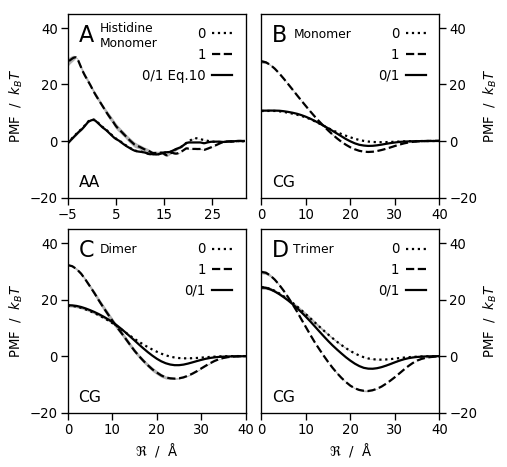

In [29]:
plt.rcParams.update({'figure.figsize': [6.5, 6]})
f, ((ax1,ax2),(ax3,ax4)) = plt.subplots(nrows=2,ncols=2)

for profile,ls in zip(['0','1'],[':','--']):
    x = allatom.loc['H']['x'+profile]*10
    y = allatom.loc['H']['y'+profile]
    Ey = allatom.loc['H']['Ey'+profile]
    ax1.plot(x,y,lw=2,label=profile,color='k',ls=ls)
    ax1.fill_between(x,y-Ey,y+Ey,alpha=.3,color='k',lw=0)
calc_ytAA(ax1,'H',6.04,7)

ah=25; at=-35; aa=2; R=2; pKa=6.04
for df,ax in zip([titr,dimer,trimer],[ax2,ax3,ax4]): 
    for profile,ls in zip(['0','1','0/1'],[':','--','-']):
        x = df.loc[ah,at,aa,R,pKa]['x'+profile]
        y = df.loc[ah,at,aa,R,pKa]['y'+profile]
        Ey = df.loc[ah,at,aa,R,pKa]['Ey'+profile]
        ax.plot(x,y,lw=2,label=profile,color='k',ls=ls)
        ax.fill_between(x,y-Ey,y+Ey,alpha=.3,color='k',lw=0)
    #if ax==ax2: calc_yt(ax,df,ah,at,aa,R,pKa,7)
    
for ax in f.axes:
    ax.set_xticks(np.arange(0,42,10)); ax.set_xlim(0,40); 
    ax.set_ylabel('PMF  /  $k_B T$'); ax.set_ylim(-20,45)
    ax.set_xticks(np.arange(0,41,10),['{:1g}'.format(i) for i in np.arange(0,41,10)])

ax1.set_xticks(np.arange(-5,32,10)); ax1.set_xlim(-5,32)
ax1.set_xticks(np.arange(-5,32,10),['{:1g}'.format(i) for i in np.arange(-5,32,10)])

ax3.set_xlabel('$\Re$  /  Å')
ax4.set_xlabel('$\Re$  /  Å')
ax3.set_xticks(np.arange(0,34,10),['{:1g}'.format(i) for i in np.arange(0,34,10)])
ax4.set_xticks(np.arange(0,34,10),['{:1g}'.format(i) for i in np.arange(0,34,10)])
    
ax1.annotate(r'A',xy=(0.06,.85), fontsize=20, xycoords='axes fraction')
ax2.annotate(r'B',xy=(0.06,.85), fontsize=20, xycoords='axes fraction')
ax3.annotate(r'C',xy=(0.06,.85), fontsize=20, xycoords='axes fraction')
ax4.annotate(r'D',xy=(0.06,.85), fontsize=20, xycoords='axes fraction')
ax1.annotate(r'AA',xy=(0.06,.06), fontsize=14, xycoords='axes fraction')
ax2.annotate(r'CG',xy=(0.06,.06), fontsize=14, xycoords='axes fraction')
ax3.annotate(r'CG',xy=(0.06,.06), fontsize=14, xycoords='axes fraction')
ax4.annotate(r'CG',xy=(0.06,.06), fontsize=14, xycoords='axes fraction')
ax1.annotate('Histidine\nMonomer',xy=(0.18,.82), fontsize=11, xycoords='axes fraction')
ax2.annotate('Monomer',xy=(0.18,.87), fontsize=11, xycoords='axes fraction')
ax3.annotate('Dimer',xy=(0.18,.87), fontsize=11, xycoords='axes fraction')
ax4.annotate('Trimer',xy=(0.18,.87), fontsize=11, xycoords='axes fraction')
ax2.yaxis.set_label_position('right'); ax2.yaxis.set_ticks_position('right')
ax4.yaxis.set_label_position('right'); ax4.yaxis.set_ticks_position('right')
ax1.legend(handlelength=1.5,handletextpad=0.5,loc='upper right',fancybox=False,borderpad=.5,
               frameon=False,fontsize=12,markerfirst=False)
ax2.legend(handlelength=1.5,handletextpad=0.5,loc='upper right',fancybox=False,borderpad=.5,
               frameon=False,fontsize=12,markerfirst=False)
ax3.legend(handlelength=1.5,handletextpad=0.5,loc='upper right',fancybox=False,borderpad=.5,
               frameon=False,fontsize=12,markerfirst=False)
ax4.legend(handlelength=1.5,handletextpad=0.5,loc='upper right',fancybox=False,borderpad=.5,
               frameon=False,fontsize=12,markerfirst=False)
f.tight_layout(w_pad=.1,h_pad=.1)    
f.savefig('figs/histidine.pdf')
plt.show()

### Lysine

187 187


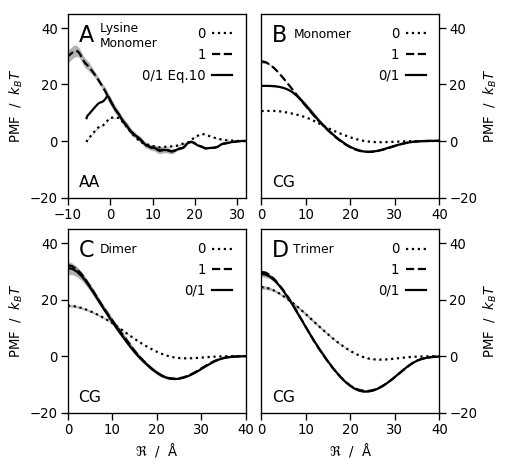

In [30]:
plt.rcParams.update({'figure.figsize': [6.5, 6]})
f, ((ax1,ax2),(ax3,ax4)) = plt.subplots(nrows=2,ncols=2)

for profile,ls in zip(['0','1'],[':','--']):
    x = allatom.loc['K']['x'+profile]*10
    y = allatom.loc['K']['y'+profile]
    Ey = allatom.loc['K']['Ey'+profile]
    ax1.plot(x,y,lw=2,label=profile,color='k',ls=ls)
    ax1.fill_between(x,y-Ey,y+Ey,alpha=.3,color='k',lw=0)
calc_ytAA(ax1,'K',10.67,7)

ah=25; at=-35; aa=2; R=2; pKa=10.67
for df,ax in zip([titr,dimer,trimer],[ax2,ax3,ax4]): 
    for profile,ls in zip(['0','1','0/1'],[':','--','-']):
        x = df.loc[ah,at,aa,R,pKa]['x'+profile]
        y = df.loc[ah,at,aa,R,pKa]['y'+profile]
        Ey = df.loc[ah,at,aa,R,pKa]['Ey'+profile]
        ax.plot(x,y,lw=2,label=profile,color='k',ls=ls)
        ax.fill_between(x,y-Ey,y+Ey,alpha=.3,color='k',lw=0)
    #if ax==ax2: calc_yt(ax,df,ah,at,aa,R,pKa,7)
    
for ax in f.axes:
    ax.set_xticks(np.arange(0,42,10)); ax.set_xlim(0,40); 
    ax.set_ylabel('PMF  /  $k_B T$'); ax.set_ylim(-20,45)
    ax.set_xticks(np.arange(0,41,10),['{:1g}'.format(i) for i in np.arange(0,41,10)])
    
ax1.set_xticks(np.arange(-10,32,10)); ax1.set_xlim(-10,32)
ax1.set_xticks(np.arange(-10,32,10),['{:1g}'.format(i) for i in np.arange(-10,32,10)])

ax3.set_xlabel('$\Re$  /  Å')
ax4.set_xlabel('$\Re$  /  Å')
ax3.set_xticks(np.arange(0,34,10),['{:1g}'.format(i) for i in np.arange(0,34,10)])
ax4.set_xticks(np.arange(0,34,10),['{:1g}'.format(i) for i in np.arange(0,34,10)])
    
ax1.annotate(r'A',xy=(0.06,.85), fontsize=20, xycoords='axes fraction')
ax2.annotate(r'B',xy=(0.06,.85), fontsize=20, xycoords='axes fraction')
ax3.annotate(r'C',xy=(0.06,.85), fontsize=20, xycoords='axes fraction')
ax4.annotate(r'D',xy=(0.06,.85), fontsize=20, xycoords='axes fraction')
ax1.annotate(r'AA',xy=(0.06,.06), fontsize=14, xycoords='axes fraction')
ax2.annotate(r'CG',xy=(0.06,.06), fontsize=14, xycoords='axes fraction')
ax3.annotate(r'CG',xy=(0.06,.06), fontsize=14, xycoords='axes fraction')
ax4.annotate(r'CG',xy=(0.06,.06), fontsize=14, xycoords='axes fraction')
ax1.annotate('Lysine\nMonomer',xy=(0.18,.82), fontsize=11, xycoords='axes fraction')
ax2.annotate('Monomer',xy=(0.18,.87), fontsize=11, xycoords='axes fraction')
ax3.annotate('Dimer',xy=(0.18,.87), fontsize=11, xycoords='axes fraction')
ax4.annotate('Trimer',xy=(0.18,.87), fontsize=11, xycoords='axes fraction')
ax2.yaxis.set_label_position('right'); ax2.yaxis.set_ticks_position('right')
ax4.yaxis.set_label_position('right'); ax4.yaxis.set_ticks_position('right')
ax1.legend(handlelength=1.5,handletextpad=0.5,loc='upper right',fancybox=False,borderpad=.5,
               frameon=False,fontsize=12,markerfirst=False)
ax2.legend(handlelength=1.5,handletextpad=0.5,loc='upper right',fancybox=False,borderpad=.5,
               frameon=False,fontsize=12,markerfirst=False)
ax3.legend(handlelength=1.5,handletextpad=0.5,loc='upper right',fancybox=False,borderpad=.5,
               frameon=False,fontsize=12,markerfirst=False)
ax4.legend(handlelength=1.5,handletextpad=0.5,loc='upper right',fancybox=False,borderpad=.5,
               frameon=False,fontsize=12,markerfirst=False)
f.tight_layout(w_pad=.1,h_pad=.1)    
f.savefig('figs/lysine.pdf')
plt.show()

### Arginine

187 187


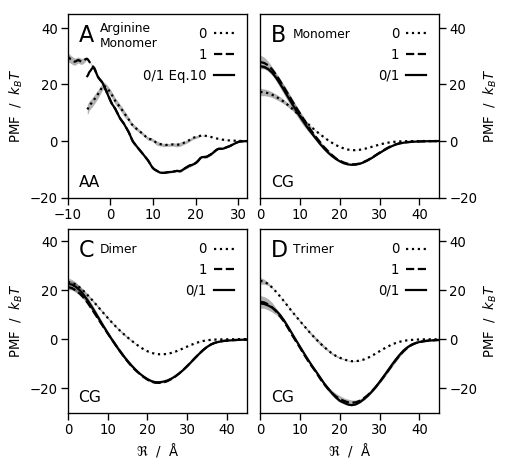

In [31]:
plt.rcParams.update({'figure.figsize': [6.5, 6]})
f, ((ax1,ax2),(ax3,ax4)) = plt.subplots(nrows=2,ncols=2)

for profile,ls in zip(['0','1'],[':','--']):
    x = allatom.loc['R']['x'+profile]*10
    y = allatom.loc['R']['y'+profile]
    Ey = allatom.loc['R']['Ey'+profile]
    ax1.plot(x,y,lw=2,label=profile,color='k',ls=ls)
    ax1.fill_between(x,y-Ey,y+Ey,alpha=.3,color='k',lw=0)
calc_ytAA(ax1,'R',12.1,7)

ah=44; at=-44; aa=2; R=2.5; pKa=12.1
for df,ax in zip([titr,dimer,trimer],[ax2,ax3,ax4]): 
    for profile,ls in zip(['0','1','0/1'],[':','--','-']):
        x = df.loc[ah,at,aa,R,pKa]['x'+profile]
        y = df.loc[ah,at,aa,R,pKa]['y'+profile]
        Ey = df.loc[ah,at,aa,R,pKa]['Ey'+profile]
        ax.plot(x,y,lw=2,label=profile,color='k',ls=ls)
        ax.fill_between(x,y-Ey,y+Ey,alpha=.3,color='k',lw=0)
    #if ax==ax2: calc_yt(ax,df,ah,at,aa,R,pKa,7)
    
for ax in f.axes:
    ax.set_xticks(np.arange(0,42,10)); ax.set_xlim(0,40); 
    ax.set_ylabel('PMF  /  $k_B T$'); ax.set_ylim(-20,45)
    ax.set_xticks(np.arange(0,41,10),['{:1g}'.format(i) for i in np.arange(0,41,10)])
    
ax1.set_xticks(np.arange(-10,32,10)); ax1.set_xlim(-10,32)
ax1.set_xticks(np.arange(-10,32,10),['{:1g}'.format(i) for i in np.arange(-10,32,10)])
ax3.set_ylim(-30,45); ax4.set_ylim(-30,45)

ax2.set_xlim(0,45); ax3.set_xlim(0,45); ax4.set_xlim(0,45)

ax3.set_xlabel('$\Re$  /  Å')
ax4.set_xlabel('$\Re$  /  Å')
    
ax1.annotate(r'A',xy=(0.06,.85), fontsize=20, xycoords='axes fraction')
ax2.annotate(r'B',xy=(0.06,.85), fontsize=20, xycoords='axes fraction')
ax3.annotate(r'C',xy=(0.06,.85), fontsize=20, xycoords='axes fraction')
ax4.annotate(r'D',xy=(0.06,.85), fontsize=20, xycoords='axes fraction')
ax1.annotate(r'AA',xy=(0.06,.06), fontsize=14, xycoords='axes fraction')
ax2.annotate(r'CG',xy=(0.06,.06), fontsize=14, xycoords='axes fraction')
ax3.annotate(r'CG',xy=(0.06,.06), fontsize=14, xycoords='axes fraction')
ax4.annotate(r'CG',xy=(0.06,.06), fontsize=14, xycoords='axes fraction')
ax1.annotate('Arginine\nMonomer',xy=(0.18,.82), fontsize=11, xycoords='axes fraction')
ax2.annotate('Monomer',xy=(0.18,.87), fontsize=11, xycoords='axes fraction')
ax3.annotate('Dimer',xy=(0.18,.87), fontsize=11, xycoords='axes fraction')
ax4.annotate('Trimer',xy=(0.18,.87), fontsize=11, xycoords='axes fraction')
ax2.yaxis.set_label_position('right'); ax2.yaxis.set_ticks_position('right')
ax4.yaxis.set_label_position('right'); ax4.yaxis.set_ticks_position('right')
ax1.legend(handlelength=1.5,handletextpad=0.5,loc='upper right',fancybox=False,borderpad=.5,
               frameon=False,fontsize=12,markerfirst=False)
ax2.legend(handlelength=1.5,handletextpad=0.5,loc='upper right',fancybox=False,borderpad=.5,
               frameon=False,fontsize=12,markerfirst=False)
ax3.legend(handlelength=1.5,handletextpad=0.5,loc='upper right',fancybox=False,borderpad=.5,
               frameon=False,fontsize=12,markerfirst=False)
ax4.legend(handlelength=1.5,handletextpad=0.5,loc='upper right',fancybox=False,borderpad=.5,
               frameon=False,fontsize=12,markerfirst=False)
f.tight_layout(w_pad=.1,h_pad=.1)    
f.savefig('figs/arginine.pdf')
plt.show()

### Stoichiometric p$K_a$ of Basic Amino Acids vs Depth of Penetration into the Lipid Bilayer

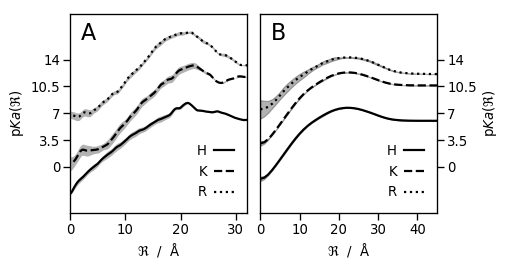

In [32]:
plt.rcParams.update({'figure.figsize': [6.5, 3.5]})
f, (ax1,ax2) = plt.subplots(nrows=1,ncols=2)

def calc_pKaz(sub,aminoacid,ah,at,aa,R,pKa,ls):
    x = titr.loc[ah,at,aa,R,pKa]['x0']
    y0 = titr.loc[ah,at,aa,R,pKa]['y0']
    Ey0 = titr.loc[ah,at,aa,R,pKa]['Ey0']
    y1 = titr.loc[ah,at,aa,R,pKa]['y1']
    Ey1 = titr.loc[ah,at,aa,R,pKa]['Ey1']
    pKaz = (y0-y1)/np.log(10)+pKa
    EpKaz = np.sqrt(Ey0**2+Ey1**2)/np.log(10)
    sub.plot(x,pKaz,lw=2,label=aminoacid,color='k',ls=ls)
    sub.fill_between(x,pKaz-EpKaz,pKaz+EpKaz,alpha=.3,color='k')
    
def calc_pKazAA(sub,aminoacid,pKa,ls):
    x0 = allatom.loc[aminoacid]['x0']*10
    y0 = allatom.loc[aminoacid]['y0']
    Ey0 = allatom.loc[aminoacid]['Ey0']
    x1 = allatom.loc[aminoacid]['x1']*10
    y1 = allatom.loc[aminoacid]['y1']
    Ey1 = allatom.loc[aminoacid]['Ey1']
    n = 25 if aminoacid == 'R' else 0
    x1 = x1 - x1[y1==y1[n:].max()]
    y1 = Akima1DInterpolator(x1, y1)(x0)
    Ey1 = Akima1DInterpolator(x1, Ey1)(x0)
    pKaz = (y0-y1)/np.log(10)+pKa
    EpKaz = np.sqrt(Ey0**2+Ey1**2)/np.log(10)
    #sub.plot(x0,y0,lw=2,label=aminoacid,color=colors[c])
    #sub.plot(x0,y1,lw=2,label=aminoacid,color=colors[c])
    sub.plot(x0,pKaz,lw=2,label=aminoacid,color='k',ls=ls)
    sub.fill_between(x0,pKaz-EpKaz,pKaz+EpKaz,alpha=.3,color='k',lw=0)
    
calc_pKazAA(ax1,'H',6.04,'-')
calc_pKazAA(ax1,'K',10.67,'--')
calc_pKazAA(ax1,'R',12.1,':')
    
calc_pKaz(ax2,'H',25,-35,2,2,6.04,'-')
calc_pKaz(ax2,'K',25,-35,2,2,10.67,'--')
calc_pKaz(ax2,'R',44,-44,2,2.5,12.1,':')

for ax in f.axes:
    ax.set_xticks(np.arange(0,41,10))
    ax.set_xticklabels(['{:1g}'.format(i) for i in np.arange(0,41,10)])
    ax.set_yticks(np.arange(0,15,3.5))
    ax.set_yticklabels(['{:1g}'.format(i) for i in np.arange(0,15,3.5)])
    ax.set_xlabel('$\Re$  /  Å'); ax.set_ylabel('p$Ka(\Re)$')
    ax.set_ylim(-6,20)

ax1.set_xlim(0,32)  
ax2.set_xlim(0,45)
    
ax2.yaxis.set_label_position('right'); ax2.yaxis.set_ticks_position('right')
ax1.annotate(r'A',xy=(0.06,.87), fontsize=20, xycoords='axes fraction')
ax2.annotate(r'B',xy=(0.06,.87), fontsize=20, xycoords='axes fraction')
ax1.legend(handlelength=1.5,handletextpad=0.5,loc='lower right',fancybox=False,borderpad=.5,
               frameon=False,fontsize=12,markerfirst=False)
ax2.legend(handlelength=1.5,handletextpad=0.5,loc='lower right',fancybox=False,borderpad=.5,
               frameon=False,fontsize=12,markerfirst=False)
f.tight_layout(w_pad=.1)    
f.savefig('figs/pKa.pdf')
plt.show()

### Demonstration of the Accuracy of the Energetics of Permeation of CG Peptides Constructed from the Monopeptide Building Block

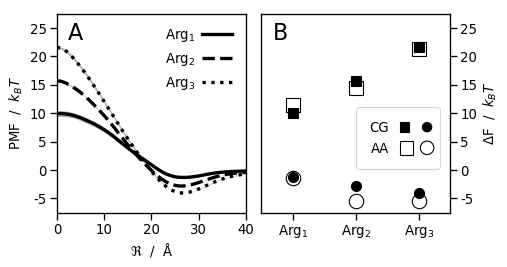

In [33]:
plt.rcParams.update({'figure.figsize': [6.5, 3.5]})
f, (ax1,ax2) = plt.subplots(nrows=1,ncols=2)

import matplotlib.patches as mpatches

class AnyObject1(object):
    pass

class AnyObject2(object):
    pass

class data_handler1(object):
    def legend_artist(self, legend, orig_handle, fontsize, handlebox):
        scale = 1
        x0, y0 = handlebox.xdescent, handlebox.ydescent
        width, height = handlebox.width, handlebox.height
        patch_sq = mpatches.Rectangle([x0, y0 + height/2 * (1 - scale) ], height * scale, height * scale, 
                facecolor='k',edgecolor='k', transform=handlebox.get_transform())
        patch_circ = mpatches.Circle([x0 + width +5 - height/2, y0 + height/2], height/2 * scale, facecolor='k',
                edgecolor='k', transform=handlebox.get_transform())

        handlebox.add_artist(patch_sq)
        handlebox.add_artist(patch_circ)
        return patch_sq
    
class data_handler2(object):
    def legend_artist(self, legend, orig_handle, fontsize, handlebox):
        scale = 1*13/9
        x0, y0 = handlebox.xdescent, handlebox.ydescent
        width, height = handlebox.width, handlebox.height
        patch_sq = mpatches.Rectangle([x0, y0 + height/2 * (1 - scale) ], height * scale, height * scale, 
                facecolor='w',edgecolor='k', transform=handlebox.get_transform())
        patch_circ = mpatches.Circle([x0 + width +5 - height/2, y0 + height/2], height/2 * scale, facecolor='w',
                edgecolor='k', transform=handlebox.get_transform())

        handlebox.add_artist(patch_sq)
        handlebox.add_artist(patch_circ)
        return patch_sq

ah=11; at=-3; R=2.5
for profile,ls,l in zip(['monomer','dimer','trimer'],['-','--',':'],[1,2,3]):
    x = hu.loc[ah,at,R,profile]['x1']
    y = hu.loc[ah,at,R,profile]['y1']
    Ey = hu.loc[ah,at,R,profile]['Ey1']
    ax1.plot(x,y,lw=3,label='Arg$_{:1g}$'.format(l),color='k',ls=ls)
    ax1.fill_between(x,y-Ey,y+Ey,alpha=.3,color='k',lw=0)

ymax = hu.loc[11,-3,2.5][['max1']].values
ymin = hu.loc[11,-3,2.5][['min1']].values
Eymax = hu.loc[11,-3,2.5][['Emax1']].values
Eymin = hu.loc[11,-3,2.5][['Emin1']].values

# data from Hu et al. DOI: dx.doi.org/10.1021/jp504853t
ymax_hu = np.array([6.94,8.64,12.80])*4.184/(.303*8.3145)
ymin_hu = np.array([-0.83,-3.33,-3.29])*4.184/(.303*8.3145)

p1 = ax2.errorbar([0,1,2],ymax,Eymax,lw=0,marker='s',color='k',
    markeredgecolor=None,ms=9,elinewidth=1.,capsize=2,capthick=1.,label='Max')
p2 = ax2.errorbar([0,1,2],ymin,Eymin,lw=0,marker='o',color='k',
      markeredgecolor=None,ms=9,elinewidth=1.,capsize=2,capthick=1.,label='Min')
p3 = ax2.plot([0,1,2],ymax_hu,lw=0,marker='s',color='w',markeredgecolor='k',ms=13,label='Max Hu et al.')
p4 = ax2.plot([0,1,2],ymin_hu,lw=0,marker='o',color='w',markeredgecolor='k',ms=13,label='Min Hu et al.')

ax1.set_xticks(np.arange(0,41,10))
ax1.set_xticklabels(['{:1g}'.format(i) for i in np.arange(0,41,10)])
ax1.set_xlabel('$\Re$  /  Å'); ax1.set_ylabel('PMF  /  $k_B T$')
ax1.set_xlim(0,40)

for ax in f.axes:
    ax.set_yticks(np.arange(-5,26,5))
    ax.set_yticklabels(['{:1g}'.format(i) for i in np.arange(-5,26,5)])
    ax.set_ylim(-7.5,27.5)

ax2.set_xticks(np.arange(0,3,1))
ax2.set_xticklabels(['Arg$_1$','Arg$_2$','Arg$_3$'])
ax2.set_ylabel('$\Delta$F  /  $k_B T$')
ax2.set_xlim(-.5,2.5)
    
ax2.yaxis.set_label_position('right'); ax2.yaxis.set_ticks_position('right')
ax1.annotate(r'A',xy=(0.06,.87), fontsize=20, xycoords='axes fraction')
ax2.annotate(r'B',xy=(0.06,.87), fontsize=20, xycoords='axes fraction')
ax1.legend(handlelength=2.3,handletextpad=0.5,loc='upper right',fancybox=False,borderpad=.5,
               frameon=False,fontsize=12,markerfirst=False)
#ax2.legend(handlelength=2.3,handletextpad=0.5,loc='upper right',fancybox=False,borderpad=.5,
#               frameon=False,fontsize=12,markerfirst=False)
ax.legend([AnyObject1(), AnyObject2()], ['CG', 'AA'], markerfirst=False,
          handler_map={AnyObject1: data_handler1(),AnyObject2: data_handler2()}, loc=(.5,.22),
          frameon=True,borderpad=1)
f.tight_layout(w_pad=.1)    
f.savefig('figs/hu.pdf')
plt.show()